In [1]:

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt


from qutip import *
from qutip import Qobj, fidelity, ket2dm, basis, tensor


from qiskit_aer.noise import pauli_error, depolarizing_error, thermal_relaxation_error

from qiskit_aer.noise import (
    NoiseModel,
    amplitude_damping_error,
    phase_damping_error,
    pauli_error,
    depolarizing_error
)

# MY NOISE AND FUNCTIONS
import depolarizing_noise
from depolarizing_noise import *
from depolarizing_noise import ibm_sherbrooke_params

import qutip_functions
from qutip_functions import *

from collections import Counter


In [2]:
# extract T1, T2, and p from the device (Qubit 3 wa snear average)
# Qubit 3: T1 = 3.73e-04 s, T2 = 3.36e-04 s, p = 2.31e-04
# tg = t_int = 5.33333333e-07
T1 = 3.73e-04 
T2 = 3.36e-04
p = 2.31e-04
tg = 5.33333333e-07


# worse noise
p_worse = p*100
cycles = 1


In [ ]:
def custom_noise(T1, T2, p, tg):
    # Calculate damping probabilities from gate time
    gamma_amp = 1 - np.exp(-tg / T1)  # For amplitude damping
    gamma_phase = 1 - np.exp(-tg / T2)  # For phase damping

    # Create noisy 1-qubit gate error (depolarizing + thermal)
    dep_error = depolarizing_error(p, 1)

    # calculate amplitude dampening and phase damping noise
    amp_damp_error = amplitude_damping_error(gamma_amp)
    phase_damp_error = phase_damping_error(gamma_phase)

    # Combine errors if desired (e.g., depolarizing followed by amplitude and phase damping)
    combined_1q_error = dep_error.compose(amp_damp_error).compose(phase_damp_error)


    # Create noise model and add all errors
    noise_model = NoiseModel()

    # Add noisy reset
    noise_model.add_all_qubit_quantum_error(combined_1q_error, ['reset'])

    # Add noisy single-qubit gates
    noise_model.add_all_qubit_quantum_error(combined_1q_error, ['x', 'h', 'i'])
    
    return noise_model


def qiskit_noise_4q_surface(psi_0, T1, T2, p, tg, cycles):

    # (Optional) Add more gates or readout errors here

    qc = QuantumCircuit(4, cycles*2)
    
    norm = np.linalg.norm(psi_0)
    psi_0 = psi_0 / norm


    


    qc.initialize(psi_0, [1, 2]) 
    #qc.h(1)
    #qc.cx(1, 2)


    qc.barrier()
    for i in range(cycles):   
        # Reset q1 and q4 (qubit indices )
        qc.reset(0)
        qc.reset(3)
        
        qc.h(0)
        qc.id(1)
        qc.id(2)
        qc.id(3)
                
        # Apply CNOT gates as per the circuit diagram
        qc.cx(0, 1)  # CNOT from qubit 0 to qubit 1
        qc.cx(0, 2)  # CNOT from qubit 0 to qubit 2
        qc.cx(1, 3)  # CNOT from qubit 2 to qubit 1
        qc.cx(2, 3)  # CNOT from qubit 2 to qubit 3
        qc.barrier()
        # Apply Identity (I) on qubit 3 (corresponding to |lg>) - no explicit gate needed

        # Apply Hadamard gate on qubit 0 before measurement in the X basis
        qc.h(0)
        qc.id(1)
        qc.id(2)
        qc.id(3)

        # Measure qubits in the X and Z bases
        qc.measure(0, 2*i)  # X_a measurement
        qc.measure(3, 2*i+1)  # Z_b measurement

        

    qc.save_density_matrix()
    # Draw the circuit
    qc.draw("mpl")
    
    return qc

In [4]:
def qiskit_simulate_noisy_4q_surface(psi_0, T1, T2, p, tg, cycles, Num_shots):
    densities_qiskit = []
    custom_noise_model = custom_noise(T1, T2, p, tg)
    qc = qiskit_noise_4q_surface(psi_0, T1, T2, p, tg, cycles)
    simulator = AerSimulator(method='statevector', noise_model=custom_noise_model)
    result = simulator.run(qc, shots=Num_shots).result()
    counts = result.get_counts()

    density_out_qiskit = result.data(0)['density_matrix']
    rho_qiskit = Qobj(density_out_qiskit)
    densities_qiskit.append(rho_qiskit)
    
    return density_out_qiskit, counts

Define Input State

In [5]:
# Define custom entangled state
A, B, C, D = 1, 0, 0, 1

state_vector = np.array([A, B, C, D])
# Define custom entangled state
norm = np.linalg.norm(state_vector)
state_vector = state_vector / norm

# Create q1-q2 2-qubit entangled state
data_state = Qobj(state_vector, dims=[[2, 2], [1, 1]])

# q0 and q3 in |0>
zero = basis(2, 0)
psi0 = tensor(zero, data_state, zero)  # q0 ⊗ (q1,q2) ⊗ q3
psi0_flat = Qobj(psi0.full())  # Flatten to 4x1

rho_ideal = ket2dm(psi0_flat)
rho_ideal

Quantum object: dims=[[16], [16]], shape=(16, 16), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5 0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.

In [6]:
num_shots = 1
rhos_qiskit = qiskit_simulate_noisy_4q_surface(state_vector, T1, T2, p, tg, cycles, num_shots)


In [7]:
rho_qiskit = Qobj(rhos_qiskit[0])
rho_qiskit  

Quantum object: dims=[[16], [16]], shape=(16, 16), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.5  0.  -0.  -0.  -0.  -0.   0.5  0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [-0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [-0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [-0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [-0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.5  0.  -0.  -0.  -0.  -0.   0.5  0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [-0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [-0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [-0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0

In [8]:
fid = fidelity(rho_qiskit, rho_ideal)

print(f"Fidelity between simulated state and ideal state: {fid:.6f}")

Fidelity between simulated state and ideal state: 1.000000


---

In [9]:
def qiskit_run_density_sweep(param_name, param_range, state_vector, p, T1, T2, tg, num_cycles, num_shots):
    """
    Run a sweep over a specified noise parameter using the Qiskit simulator
    to generate a dictionary of noisy density matrices for each parameter value.

    Returns:
    - density_dict: dict mapping param_val → list of density matrix Qobj results with dims=[[16], [16]]
    """
    density_dict = {}

    for val in param_range:
        # Set the varied parameter
        kwargs = {'p': p, 'T1': T1, 'T2': T2, 'tg': tg}
        kwargs[param_name] = val

        rho_list = []
        result_rho, counts = qiskit_simulate_noisy_4q_surface(state_vector, **kwargs, cycles=num_cycles, Num_shots=num_shots)

        # Convert to ndarray if needed
        if hasattr(result_rho, 'data'):  # Qiskit DensityMatrix
            result_rho = np.asarray(result_rho)

        # Wrap with flattened dims
        qobj_rho = Qobj(result_rho, dims=[[16], [16]])
        rho_list.append(qobj_rho)

        density_dict[val] = rho_list

    return density_dict

#p_range = np.linspace(0,10,10)*p
#num_shots = 10
#qiskit_run_density_sweep('p', p_range, state_vector, p, T1, T2, tg, cycles, num_shots)


In [21]:

# Generate probability values for the parameter sweep
p_range = np.logspace(-1, 3.2, num=30) * p

# Simulation settings
num_shots = 800
num_cycles = 1

# -------------------------------
# Qiskit: Run density matrix simulations
# -------------------------------
qiskit_density_results = qiskit_run_density_sweep(
    'p', p_range, state_vector, p, T1, T2, tg, 
    num_cycles, num_shots=num_shots
)


# Compute fidelity for each density matrix against the ideal state
qiskit_fidelity_samples = {}
qiskit_avg_fidelity = {}
qiskit_std_fidelity = {}

qiskit_trace_closeness = {}
qiskit_avg_trace_closeness = {}
qiskit_std_trace_closeness = {}


for p_val, density_list in qiskit_density_results.items():
    fidelities = [fidelity(rho, psi0_flat) for rho in density_list]
    
    trace_vals = [psi.norm()**2 for psi in density_list]
    closeness_vals = [1 - abs(1 - tr) for tr in trace_vals]
    qiskit_trace_closeness[p_val] = closeness_vals
    qiskit_avg_trace_closeness[p_val] = np.mean(closeness_vals)
    qiskit_std_trace_closeness[p_val] = np.std(closeness_vals)

    qiskit_fidelity_samples[p_val] = fidelities
    qiskit_avg_fidelity[p_val] = np.mean(fidelities)
    qiskit_std_fidelity[p_val] = np.std(fidelities)

# Prepare Qiskit data for plotting
qiskit_plot_x = list(qiskit_avg_fidelity.keys())

# Fidelity
qiskit_fidelity_plot_y = [qiskit_avg_fidelity[p] for p in qiskit_plot_x]
qiskit_fidelity_plot_yerr = [qiskit_std_fidelity[p] for p in qiskit_plot_x]

# Trace Closeness to 1
qiskit_trace_closeness_y = [qiskit_avg_trace_closeness[p] for p in qiskit_plot_x]
qiskit_trace_closeness_yerr = [qiskit_std_fidelity[p] for p in qiskit_plot_x]


# -------------------------------
# QuTiP: Run parameter sweep and analyze fidelity/closeness
# -------------------------------
(
    qutip_results,
    qutip_closeness_samples,
    qutip_fidelity_samples,
    qutip_avg_closeness,
    qutip_avg_fidelity,
    qutip_fid_given_closeness_samples,
    qutip_avg_fid_given_closeness
) = run_parameter_sweep_with_closeness(
    param_name='p',
    param_range=p_range,
    shots=num_shots,
    psi0_flat=psi0_flat,
    p=p, T1=T1, T2=T2, tg=tg,
    simulate_func=simulate_noisy_4_qubit_surface,
    ideal_state=psi0_flat,
    additional_noise=True
)

# Prepare QuTiP data for plotting
qutip_plot_x = p_range
qutip_closeness_y = [qutip_avg_closeness[p] for p in qutip_plot_x]
qutip_fidelity_y = [qutip_avg_fidelity[p] for p in qutip_plot_x]
qutip_fid_given_close_y = [qutip_avg_fid_given_closeness[p] for p in qutip_plot_x]

qutip_closeness_yerr = [np.std(qutip_closeness_samples[p]) for p in qutip_plot_x]
qutip_fidelity_yerr = [np.std(qutip_fidelity_samples[p]) for p in qutip_plot_x]
qutip_fid_given_close_yerr = [np.std(qutip_fid_given_closeness_samples[p]) for p in qutip_plot_x]


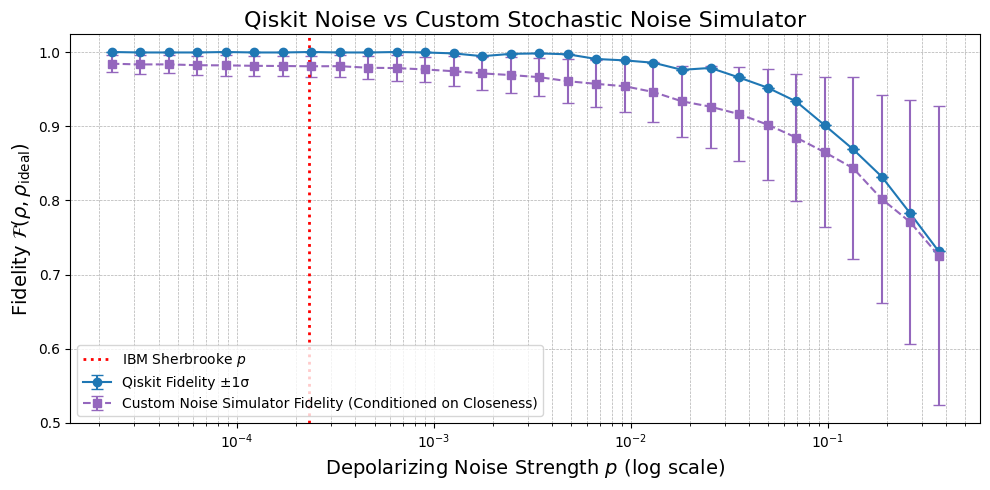

In [23]:
plt.figure(figsize=(10, 5))

# Qiskit fidelity in soft blue
plt.errorbar(qiskit_plot_x, qiskit_fidelity_plot_y, yerr=qiskit_fidelity_plot_yerr,
             fmt='o-', capsize=4, color='#1f77b4', label='Qiskit Fidelity ±1σ')  # soft blue

# Custom simulator fidelity in soft purple
plt.errorbar(qutip_plot_x, qutip_fid_given_close_y, yerr=qutip_fid_given_close_yerr,
             fmt='s--', capsize=4, color='#9467bd', label='Custom Noise Simulator Fidelity (Conditioned on Closeness)')  # soft purple

# Vertical line for reference depolarizing p
plt.axvline(p, color='red', linestyle=':', linewidth=2, label=r'IBM Sherbrooke $p$')

plt.xscale('log')
plt.xlabel(r'Depolarizing Noise Strength $p$ (log scale)', fontsize=14)
plt.ylabel(r'Fidelity $\mathcal{F}(\rho, \rho_{\mathrm{ideal}})$', fontsize=14)
plt.title('Qiskit Noise vs Custom Stochastic Noise Simulator', fontsize=16)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


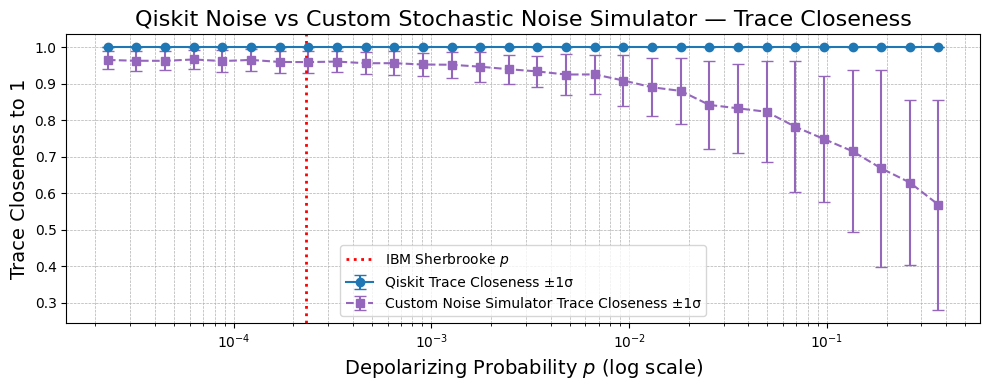

In [20]:
plt.figure(figsize=(10, 4))

# Qiskit trace closeness in soft blue
plt.errorbar(qiskit_plot_x, qiskit_trace_closeness_y, yerr=qiskit_trace_closeness_yerr,
             fmt='o-', capsize=4, color='#1f77b4', label='Qiskit Trace Closeness ±1σ')

# Custom simulator trace closeness in soft purple
plt.errorbar(qutip_plot_x, qutip_closeness_y, yerr=qutip_closeness_yerr,
             fmt='s--', capsize=4, color='#9467bd', label='Custom Noise Simulator Trace Closeness ±1σ')

# Vertical line for reference depolarizing p
plt.axvline(p, color='red', linestyle=':', linewidth=2, label=r'IBM Sherbrooke $p$')

plt.xscale('log')
plt.xlabel(r'Depolarizing Probability $p$ (log scale)', fontsize=14)
plt.ylabel(r'Trace Closeness to 1', fontsize=14)
plt.title('Qiskit Noise vs Custom Stochastic Noise Simulator — Trace Closeness', fontsize=16)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
def qiskit_hellinger_sweep(tg_vals, qiskit_density_results, psi0_flat):
    qiskit_hellinger_dict = {}
    qiskit_avg_hellinger = {}
    qiskit_std_hellinger = {}

    for val in tg_vals:
        densities = qiskit_density_results[val]
        hellinger_vals = [hellinger_distance_diag(Qobj(rho), ket2dm(psi0_flat)) for rho in densities]
        
        qiskit_hellinger_dict[val] = hellinger_vals
        qiskit_avg_hellinger[val] = np.mean(hellinger_vals)
        qiskit_std_hellinger[val] = np.std(hellinger_vals)
        
    return qiskit_hellinger_dict, qiskit_avg_hellinger, qiskit_std_hellinger



def run_hellinger_sweep_qutip(param_name, param_range, shots, psi0_flat, p, T1, T2, tg, simulate_func, ideal_state, additional_noise=False):
    """
    Run a sweep over a noise parameter and compute the Hellinger distance (diagonal only)
    between the simulated output state and the ideal state for each shot.
    """

    hellinger_dict = {}
    avg_hellinger = {}
    std_hellinger = {}

    for val in param_range:
        kwargs = {'p': p, 'T1': T1, 'T2': T2, 'tg': tg}
        kwargs[param_name] = val

        counts, psi_outcomes = simulate_func(psi0_flat, **kwargs, shots=shots, additional_noise=additional_noise)

        hellinger_vals = [hellinger_distance_diag(ket2dm(psi), ket2dm(ideal_state)) for psi in psi_outcomes]
        hellinger_dict[val] = hellinger_vals
        avg_hellinger[val] = np.mean(hellinger_vals)
        std_hellinger[val] = np.std(hellinger_vals)

    return hellinger_dict, avg_hellinger, std_hellinger




In [16]:
# Assume default p, T1, T2, tg are already defined
tg_vals = np.logspace(-2, 3.3, num=20) * tg  # 0.1p to 10000tg, log scale
num_shots = 500

# -------------------------------
# Qiskit: Run density matrix simulations
# -------------------------------

# Run for Qiskit simulator — must return same format
qiskit_density_results = qiskit_run_density_sweep(
    param_name='tg',
    param_range=tg_vals,
    state_vector=state_vector,
    p=p, T1=T1, T2=T2, tg=tg,
    num_cycles=num_cycles,
    num_shots=num_shots
)

qiskit_hellinger_dict, qiskit_avg_hellinger, qiskit_std_hellinger = qiskit_hellinger_sweep(tg_vals, qiskit_density_results, psi0_flat)


# -------------------------------
# QuTiP: Run parameter sweep and analyze fidelity/closeness
# -------------------------------

# Run for custom noise simulator (QuTiP)
qutip_hellinger_dict, qutip_avg_hellinger, qutip_std_hellinger = run_hellinger_sweep_qutip(
    param_name='tg',
    param_range=tg_vals,
    shots=num_shots,
    psi0_flat=psi0_flat,
    p=p, T1=T1, T2=T2, tg=tg,
    simulate_func=simulate_noisy_4_qubit_surface,
    ideal_state=psi0_flat,
    additional_noise=True
)



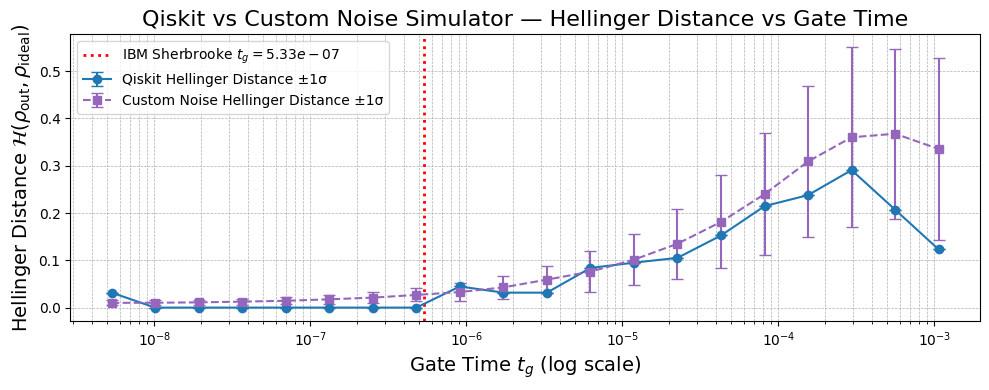

In [19]:
plt.figure(figsize=(10, 4))

# Qiskit Hellinger distance
plt.errorbar(
    tg_vals, list(qiskit_avg_hellinger.values()), yerr=list(qiskit_std_hellinger.values()),
    fmt='o-', capsize=4, color='#1f77b4',
    label='Qiskit Hellinger Distance ±1σ'
)

# QuTiP Hellinger distance
plt.errorbar(
    tg_vals, list(qutip_avg_hellinger.values()), yerr=list(qutip_std_hellinger.values()),
    fmt='s--', capsize=4, color='#9467bd',
    label='Custom Noise Hellinger Distance ±1σ'
)

# Reference vertical line for base p
plt.axvline(tg, color='red', linestyle=':', linewidth=2, label=fr'IBM Sherbrooke $t_g = {tg: .2e}$')

plt.xscale('log')
plt.xlabel(r'Gate Time $t_g$ (log scale)', fontsize=14)
plt.ylabel(r'Hellinger Distance $\mathcal{H}(\rho_{\text{out}}, \rho_{\text{ideal}})$', fontsize=14)
plt.title('Qiskit vs Custom Noise Simulator — Hellinger Distance vs Gate Time', fontsize=16)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()